# Generalized Wiener Filtering

Here we define a module which defines custum types for FFT and cls

In [1]:
module FFTandCls
using PyCall, Dierckx
export FFTgrid, MatrixCls, class, sim_xk, radial_power, squash, squash!


##########################################################
# Custom type definitions
##############################################################

# ---- Holds grid, model and planned FFT parameters for the quadratic estimate.
immutable FFTgrid{dm, T}
	period::Float64
	nside::Int64
	deltx::Float64
	deltk::Float64
	nyq::Float64
	x::Array{Array{Float64,dm},1}
	k::Array{Array{Float64,dm},1}
	r::Array{Float64,dm}
	FFT::T  # saved plan for fast fft
end

#---- Holds the cls expanded out to the 2 d spectral matrices.
immutable MatrixCls{dm}
	cϕϕk::Array{Float64,dm}
	cTTk::Array{Float64,dm}
	cTEk::Array{Float64,dm}
	cEEk::Array{Float64,dm}
	cBBk::Array{Float64,dm}
	cTTnoisek::Array{Float64,dm}
	cEEnoisek::Array{Float64,dm}
	cBBnoisek::Array{Float64,dm}
end

##########################################################
# Type constructors
##############################################################

function FFTgrid(dm, period, nside)
	dm_nsides = fill(nside,dm)   # [nside,...,nside] <- dm times
	deltx     = period / nside
	deltk     = 2π / period
	nyq       = 2π / (2deltx)
	x         = [fill(NaN, dm_nsides...) for i = 1:dm]
	k         = [fill(NaN, dm_nsides...) for i = 1:dm]
	r         =  fill(NaN, dm_nsides...)
	tmp       = rand(Complex{Float64},dm_nsides...)
	unnormalized_FFT = plan_fft(tmp; flags = FFTW.PATIENT, timelimit = 10)
	FFT = complex( (deltx / √(2π))^dm ) * unnormalized_FFT
	FFT \ tmp   # <-- initialize fast ifft
	g = FFTgrid{dm, typeof(FFT)}(period, nside, deltx, deltk, nyq, x, k, r, FFT)
	g.x[:], g.k[:] = getgrid(g)
	g.r[:]  =  √(sum([abs2(kdim) for kdim in g.k]))
	return g
end

function MatrixCls{dm,T}(g::FFTgrid{dm,T}, cls; σTTarcmin=0.0, σEEarcmin=0.0,  σBBarcmin=0.0, beamFWHM=0.0)
	cϕϕk = cls_to_cXXk(cls[:ell], cls[:ϕϕ], g.r)
	cTTk = cls_to_cXXk(cls[:ell], cls[:tt], g.r)
	cTEk = cls_to_cXXk(cls[:ell], cls[:te], g.r)
	cEEk = cls_to_cXXk(cls[:ell], cls[:ee], g.r)
	cBBk = cls_to_cXXk(cls[:ell], cls[:bb], g.r)
	cTTnoisek = cNNkgen(g.r; σarcmin=σTTarcmin, beamFWHM=beamFWHM)
	cEEnoisek = cNNkgen(g.r; σarcmin=σEEarcmin, beamFWHM=beamFWHM)
	cBBnoisek = cNNkgen(g.r; σarcmin=σBBarcmin, beamFWHM=beamFWHM)
	MatrixCls{dm}(cϕϕk, cTTk, cTEk, cEEk, cBBk, cTTnoisek, cEEnoisek, cBBnoisek)
end

##########################################################
# Type constructor helpers
##############################################################

function cls_to_cXXk{dm}(ell, cxxls, r::Array{Float64, dm})
	spl = Spline1D(ell, cxxls; k=1, bc="zero", s=0.0)
	return squash(map(spl, r))::Array{Float64, dm}
end

function cNNkgen{dm}(r::Array{Float64,dm}; σarcmin=0.0, beamFWHM=0.0)
	beamSQ = exp(- (beamFWHM ^ 2) * (abs2(r) .^ 2) ./ (8 * log(2)) )
	σrad = σarcmin * (π / 180 / 60) ^ (dm / 2)
	return ones(size(r)) .* σrad .^ 2 ./ beamSQ
end

function getgrid{T}(g::FFTgrid{2,T})
	xco_side, kco_side = getxkside(g)
	kco1, kco2 = meshgrid(kco_side, kco_side)
	xco1, xco2 = meshgrid(xco_side, xco_side)
	kco    = Array{Float64,2}[kco1, kco2]
	xco    = Array{Float64,2}[xco1, xco2]
	return xco, kco
end

function getxkside{dm,T}(g::FFTgrid{dm,T})
	deltx    = g.period / g.nside
	deltk    = 2π / g.period
	xco_side = zeros(g.nside)
	kco_side = zeros(g.nside)
	for j in 0:(g.nside-1)
		xco_side[j+1] = (j < g.nside/2) ? (j*deltx) : (j*deltx - g.period)
		kco_side[j+1] = (j < g.nside/2) ? (j*deltk) : (j*deltk - 2*π*g.nside/g.period)
	end
	xco_side, kco_side
end

function meshgrid(side_x,side_y)
    	nx = length(side_x)
    	ny = length(side_y)
    	xt = repmat(vec(side_x).', ny, 1)
    	yt = repmat(vec(side_y)  , 1 , nx)
    	return xt, yt
end

##########################################################
# Miscellaneous functions
##############################################################
@pyimport classy

function class(;ϕscale = 0.1, ψscale = 0.1, lmax = 6_000, r = 1.0, omega_b = 0.0224567, omega_cdm=0.118489, tau_reio = 0.128312, theta_s = 0.0104098, logA_s_1010 = 3.29056, n_s =  0.968602)
    cosmo = classy.Class()
    cosmo[:struct_cleanup]()
    cosmo[:empty]()
    params = Dict(
        "output"        => "tCl, pCl, lCl",
        "modes"         => "s,t",
        "lensing"       => "yes",
        "l_max_scalars" => lmax + 500,
        "l_max_tensors" => 3_000, #lmax + 500,
        "omega_b"       => omega_b,
        "omega_cdm"     => omega_cdm,
        "tau_reio"      => tau_reio,
        "100*theta_s"   => 100*theta_s,
        "ln10^{10}A_s"  => logA_s_1010,
        "n_s"           => n_s,
        "r"             => r,
        #"k_pivot"       => 0.05,
        #"k_step_trans"  => 0.1, # 0.01 for super high resolution
        #"l_linstep"     => 10,  # 1 for super high resolution
    )
    cosmo[:set](params)
    cosmo[:compute]()
    cls_ln = cosmo[:lensed_cl](lmax)
    cls = cosmo[:raw_cl](lmax)
    rtn = Dict{Symbol, Array{Float64,1}}(
            :ell      => cls["ell"],
            :ln_tt  => cls_ln["tt"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :ln_ee  => cls_ln["ee"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :ln_bb  => cls_ln["bb"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :ln_te  => cls_ln["te"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :ln_tϕ  => cls_ln["tp"] * (10^6 * cosmo[:T_cmb]()),
            :tt => cls["tt"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :ee => cls["ee"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :bb => cls["bb"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :te => cls["te"] * (10^6 * cosmo[:T_cmb]()) ^ 2,
            :tϕ => cls["tp"] * (10^6 * cosmo[:T_cmb]()),
            :ϕϕ     => ϕscale.*cls["pp"],
    )
    return rtn
end

function radial_power{dm,T}(fk, smooth::Number, g::FFTgrid{dm,T})
	rtnk = Float64[]
	dk = g.deltk
	kbins = collect((smooth*dk):(smooth*dk):(g.nyq))
	for wavenumber in kbins
		indx = (wavenumber-smooth*dk) .< g.r .<= (wavenumber+smooth*dk)
		push!(rtnk, sum(abs2(fk[indx]).* (dk.^dm)) / sum(indx))
	end
	return kbins, rtnk
end

# -------- Simulate a mean zero Gaussian random field in the pixel domain given a spectral density.
function sim_xk{dm, T}(cXXk::Array{Float64,dm}, g::FFTgrid{dm, T})
	wx, wk = white_wx_wk(g)
	zk = √(cXXk) .* wk
	zx = real(g.FFT \ zk)
	return zx, zk
end

# ----- white noise
function white_wx_wk{dm, T}(g::FFTgrid{dm, T})
	dx  = g.deltx ^ dm
	wx = randn(size(g.r)) ./ √(dx)
	wk = g.FFT * wx
	return wx, wk
end

squash{T<:Number}(x::T)  = isnan(x) ? zero(T) : isfinite(x) ? x : zero(T)
function squash!{dm,T}(x::Array{T,dm}, mask::BitArray{dm}=trues(size(x)))
	@inbounds @simd for i in eachindex(x)
		if !mask[i] || !isfinite(x[i]) || isnan(x[i])
			x[i] = zero(T)
		end
	end
	return x
end
function squash{dm,T}(x::Array{T,dm}, mask::BitArray{dm}=trues(size(x)))
	y = copy(x)
	return squash!(y, mask)
end


end # end Module

FFTandCls

# Message Passing 

Here we impliment the message passing algorithm.

## Load the module and initialize FFT grid and cls

In [2]:
FFTW.set_num_threads(CPU_CORES)
using FFTandCls
using PyPlot

# ----  set the seed
seedstart = rand(UInt64)
srand(seedstart)

# --- set grid geometry and cls
dm     = 2
nside  = nextprod([2,3,5,7], 1024/2)
period =  2*π / 20 # radians, nside * pi / (180*60) gives 1 arcmin pixels
fsky   =  (period)^2 / (4π)
g      = FFTgrid(dm, period, nside)
cls = class();

## Functions for computing the conditional expected value of the Gibbs conditionals

In [15]:
# ---- get the low pass coefficients in linear order
function get_low_coeffsk(vk, kmask, g)
    return vk[kmask]
end

# ---- convert the low pass coefficients in linear order to matrix form
function embed_low_coeffs(low_coeffsk, kmask, g)
    vk = zeros(Complex{Float64}, size(g.r))
    vk[kmask] = low_coeffsk
    return vk
end

# --- precompute the low rank inverse
function get_lowrankinv(Ntildx, mCls, kmask, g)
    Λ         = get_low_coeffsk(mCls.cTTk ./ (g.deltx ^ 2), kmask, g)
    fft_invÑ  = g.FFT * (1 ./ Ntildx)
    k1        = get_low_coeffsk(g.k[1], kmask, g)
    k2        = get_low_coeffsk(g.k[2], kmask, g)
    n         = length(Λ)
    mat       = Array(Complex{Float64}, n,n)
    for k in 1:n, j in 1:n
        indxcol = findmin(abs2(k1[j] - k1[k] - g.k[1][1,:]))[2]
        indxrow = findmin(abs2(k2[j] - k2[k] - g.k[2][:,1]))[2]
        mat[j,k] = (g.deltk^2 / (2π)) * fft_invÑ[indxrow, indxcol]
    end
    lowrank    = diagm(1./Λ) + mat
    lowrankinv = inv(lowrank)
    return lowrankinv
end

# --- function for computing E(lx| hbarx , hk, dx)
function wf_lx(dx, hbarx, Ntildx, lowrankinv, mCls, kmask, g)
    r1   = (dx - hbarx) ./ Ntildx
    r2   = g.FFT * r1
    r3   = get_low_coeffsk(r2, kmask, g)
    r4   = lowrankinv * r3
    #r5   = real(g.FFT \ embed_low_coeffs(r4, kmask, g))
    #r6   = r5 ./ Ntildx
    #r7   = r1 - r6
    #r8   = g.FFT * r7
    #r8 .*= mCls.cTTk .* kmask ./ (g.deltx ^ 2)
    #lx   =  real(g.FFT \ r8)
    lx    = real(g.FFT \ embed_low_coeffs(r4, kmask, g))
    return lx
end


# --- function for computing E(hbarx | lx, hx, dx)
function wf_hbarx(hx, lx, dx, Nbarx, Ntildx)
    hbarx = Array(Float64, size(hx))
    @inbounds @simd for i in eachindex(hbarx)
        hbarx[i] = ((dx[i]-lx[i])/Ntildx[i] + hx[i]/Nbarx[i]) / (1/Nbarx[i] + 1/Ntildx[i])
    end
    return hbarx
end


# --- function for computing E(hk| lx, hbark , dx)
function wf_hk(hbark, nbar_prop_var, mCls, hmask, g)
    hk = Array(Complex{Float64}, size(hbark))
    @inbounds @simd for i in eachindex(hk)
        hk[i] = mCls.cTTk[i] * hbark[i] / (nbar_prop_var * mCls.cTTnoisek[i]  + mCls.cTTk[i])
    end
    return hk .* hmask
end


# --- stopping criterion
function wferror(wftest, dx, Nx, mCls, g)
    b  = squash!(dx ./ Nx)
    Ax = (Nx .!= Inf).*real(g.FFT \ squash!((g.FFT * wftest) ./ (mCls.cTTk/(g.deltx^2)) ))  + squash!(wftest ./ Nx)
    return norm(Ax - b)/norm(b), norm(Ax - b)
end

wferror (generic function with 1 method)

## Now run the algorithm on a simulation

Set the noise level, the beam and the masked region

In [4]:
# ---- matrix form of the cls
mCls = MatrixCls(g, cls; σTTarcmin = 15.0/√(fsky))
beamFWHMarcmin  = 1.0
maskx = falses(g.r) #g.x[1] .>= 0.6*period/2
beamFWHMradians = beamFWHMarcmin * (π / 180 / 60)
mCls.cTTk[:] = mCls.cTTk .* exp(-abs2(beamFWHMradians .* g.r) / 8 / log(2));

Nx      = (1000*(g.x[1] .> 0.6*period/2) + 1) .* mCls.cTTnoisek[3,3] ./ (g.deltx ^ 2)
nbar_prop_varA = 0.5
NbarxA  =  nbar_prop_varA * ones(size(g.x[1])) .* mCls.cTTnoisek[3,3] ./ (g.deltx ^ 2)
NtildxA =  Nx - NbarxA
NtildxA[maskx] = Inf


Inf

Simulate the tempurature map and the noise

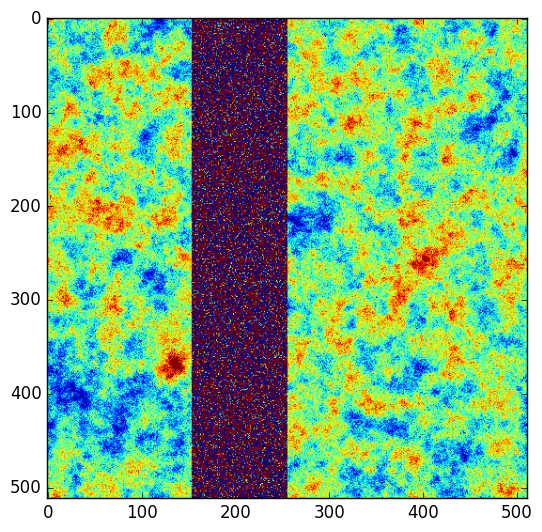

PyObject <matplotlib.image.AxesImage object at 0x317df5610>

In [5]:
# ---- simulate t and noise
tx, tk  = sim_xk(mCls.cTTk, g)
dx      = tx + randn(size(g.r)) .* √(Nx)
dx[maskx] = 0.0
imshow(dx, vmin = -400, vmax = 400)

Use Sherman-Morrison Woodbury ...

In [6]:
k1max, k2max, k3max, k4max, k5max = 10g.deltk, 14g.deltk, 17g.deltk, 19g.deltk, 21g.deltk
l1mask = (abs(g.k[1]./6) .< k1max) & (abs(g.k[2]) .< k1max)
l2mask = (abs(g.k[1]./6) .< k2max) & (abs(g.k[2]) .< k2max) & !l1mask
l3mask = (abs(g.k[1]./6) .< k3max) & (abs(g.k[2]) .< k3max) & !l1mask & !l2mask
l4mask = (abs(g.k[1]./6) .< k4max) & (abs(g.k[2]) .< k4max) & !l1mask & !l2mask & !l3mask
l5mask = (abs(g.k[1]./6) .< k5max) & (abs(g.k[2]) .< k5max) & !l1mask & !l2mask & !l3mask & !l4mask
hmask  = (abs(g.k[1]./6) .< Inf  ) & (abs(g.k[2]) .< Inf)   & !l1mask & !l2mask & !l3mask & !l4mask & !l5mask

512x512 BitArray{2}:
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false  …  false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
     ⋮                        

This is the number of modes in the low rank models

In [7]:
sum(l1mask), sum(l2mask), sum(l3mask), sum(l4mask), sum(l5mask)

(2261,2248,2190,1700,1892)

Now decide how much homogenious varianace to contribute to N̄ and then pre-compute the low rank inverses

In [8]:
@time lowrankinv1A = get_lowrankinv(NtildxA, mCls, l1mask, g)
@time lowrankinv2A = get_lowrankinv(NtildxA, mCls, l2mask, g)
@time lowrankinv3A = get_lowrankinv(NtildxA, mCls, l3mask, g)
@time lowrankinv4A = get_lowrankinv(NtildxA, mCls, l4mask, g)
@time lowrankinv5A = get_lowrankinv(NtildxA, mCls, l5mask, g);

 44.790608 seconds (51.50 M allocations: 120.047 GB, 23.16% gc time)
 44.378255 seconds (50.54 M allocations: 118.654 GB, 23.68% gc time)
 41.904570 seconds (47.96 M allocations: 112.611 GB, 23.60% gc time)
 25.271415 seconds (28.90 M allocations: 67.861 GB, 23.75% gc time)
 31.326151 seconds (35.80 M allocations: 84.053 GB, 23.71% gc time)


Initialize the message passing fields

In [9]:
l1x, l2x, l3x, l4x, l5x, hbarxA   = zeros(dx), zeros(dx), zeros(dx), zeros(dx), zeros(dx), zeros(dx)
hk      = zeros(Complex{Float64}, size(g.r));

In [10]:
nruns = 50
λcool = ones(nruns);
#stepdown = linspace(mCls.cTTk[3,3], 1, round(Int64,0.8*nruns))
#for i in 1:length(stepdown)
#     λcool[i] = stepdown[i]
#end

50-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮  
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

Now run the iterations

In [16]:
for counter = 1:nruns
    l1x    = wf_lx(dx, hbarxA + l2x + l3x + l4x + l5x, NtildxA, lowrankinv1A, mCls, l1mask, g)
    l2x    = wf_lx(dx, hbarxA + l1x + l3x + l4x + l5x, NtildxA, lowrankinv2A, mCls, l2mask, g)
    l3x    = wf_lx(dx, hbarxA + l1x + l2x + l4x + l5x, NtildxA, lowrankinv3A, mCls, l3mask, g)
    l4x    = wf_lx(dx, hbarxA + l1x + l2x + l3x + l5x, NtildxA, lowrankinv4A, mCls, l4mask, g)
    l5x    = wf_lx(dx, hbarxA + l1x + l2x + l3x + l4x, NtildxA, lowrankinv5A, mCls, l5mask, g)
    hbarxA  = wf_hbarx(real(g.FFT \ hk), l1x + l2x + l3x + l4x + l5x, dx, λcool[counter] * NbarxA, NtildxA)
    hk     = wf_hk(g.FFT * hbarxA, nbar_prop_varA, mCls, hmask, g)
    @show wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x, dx, Nx, mCls, g)
end

# # regular message passing
# for counter = 1:nruns
#     hbarxA  = wf_hbarx(real(g.FFT \ hk), zeros(size(g.r)), dx, λcool[counter] * NbarxA, NtildxA)
#     hk     = wf_hk(g.FFT * hbarxA, nbar_prop_varA, mCls, trues(g.r), g)
#     @show wferror(real(g.FFT \ hk), dx, Nx, mCls, g)
# end


wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.5257887021041,198.7154419400624)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.60808685737472,198.99973033774333)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.633642174980636,199.08800789719194)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.64193197208853,199.11664393562017)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.64474137243504,199.12634864795945)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.645671374774956,199.1295612214878)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.64592808556676,199.13044799591705)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.64594265227923,199.13049831475269)
wferror(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x,dx,Nx,mCls,g) = (57.64587482763576,199.1302640232409)
wferror(real

Plot the results

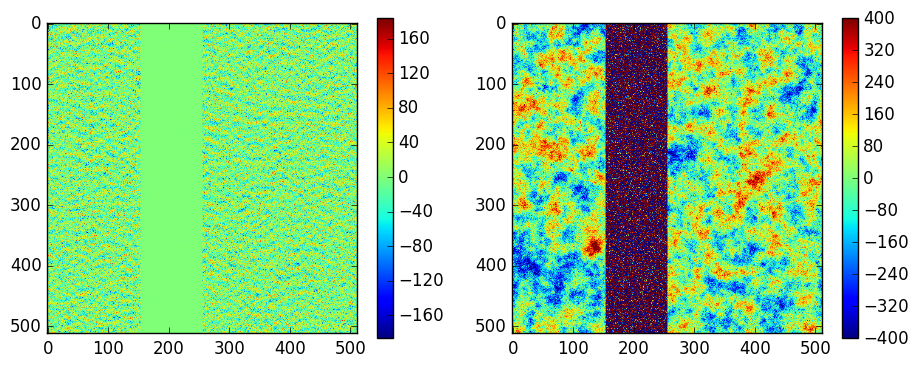

PyObject <matplotlib.colorbar.Colorbar object at 0x32212f190>

In [12]:
using PyPlot 
figure(figsize = (11,4))
subplot(1,2,1)
# imshow(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x, vmin = -400, vmax = 400); colorbar()
# imshow(real(g.FFT \ hk) + l1x + l2x + l3x + l4x + l5x, vmin = -400, vmax = 400); colorbar()
imshow(hbarxA); colorbar()
subplot(1,2,2)
imshow(dx, vmin = -400, vmax = 400); colorbar()

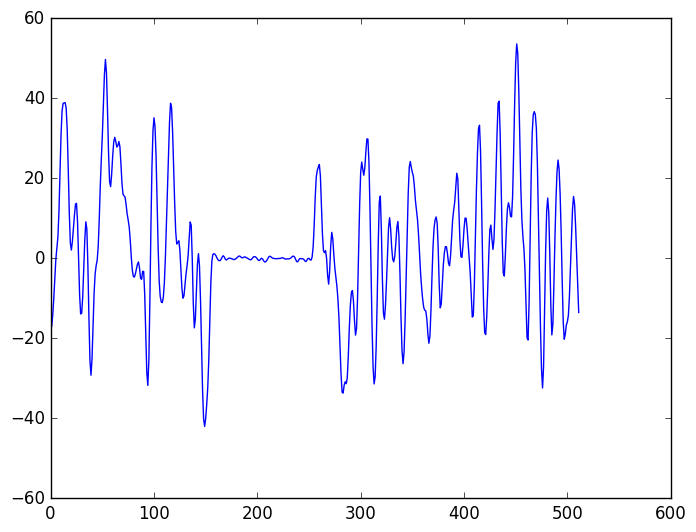

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x331c93dd0>

In [13]:
plot(real(g.FFT \ hk)[100,:]')

This compares the low rank signal-to-noise ratio to the noise

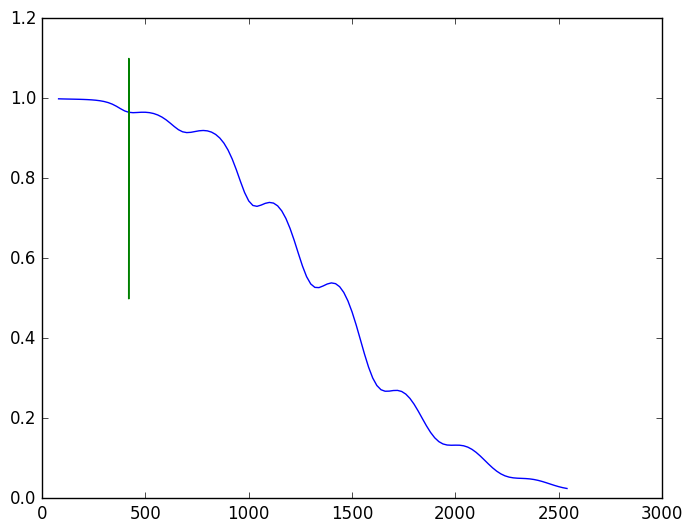

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31cf67650>

In [14]:
    nby2 = round(Int, nside/4)
    plot(g.r[5:nby2,1],mCls.cTTk[5:nby2,1] ./ (mCls.cTTk[5:nby2,1] +  mCls.cTTnoisek[5:nby2,1]))
    plot([k5max-1,k5max, k5max], [.5, 1.1,.5])

# Pre-Conditioned Conjugate Gradient